# Принятие решений в бизнесе на основе данных

**Описание проекта**


Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

- Приоритизация гипотез
- Анализ A/B-теста 
- Выводы. 

# Описание данных

**Файл hypothesis.csv:**

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Файл orders.csv:**

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Файл visitors.csv:**

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Ознакомление с данными
### Импорт библиотек и обзор таблиц

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st

In [2]:
#читаем таблицы
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

In [3]:
#смотрим информацию по hypothesis и снимаем ограничение на ширину столбцов, иначе ничего не прочитать
pd.set_option('display.max_colwidth', None)
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [5]:
#смотрим orders, но так как строк тут много, ограничиваемся первыми 5.
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
#ищем пропуски
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [7]:
#посмотрим первую и последнюю дату в orders
display(orders['date'].max())
display(orders['date'].min())

'2019-08-31'

'2019-08-01'

In [8]:
#посмотрим какие группы у нас есть в orders
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [9]:
#так же смотрим на visitors
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
#ищем пропуски
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [11]:
#посмотрим какие группы у нас есть в visitors
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [12]:
#посчитаем количество групп
visitors.group.value_counts()

B    31
A    31
Name: group, dtype: int64

In [13]:
#посчитаем количество участников групп
visitors.groupby('group').agg({'visitors':'sum'})

,visitors
group,
A,18736
B,18916


In [14]:
#посмотрим первую и последнюю дату в visitors
display(visitors['date'].max())
display(visitors['date'].min())

'2019-08-31'

'2019-08-01'

**Промежуточный итог:**  
Столбцы с датами в таблицах orders и visitors имеют тип данных object, для дальнейшей работы необходимо поменять.  
Пропусков на первый взгляд нет.  
Даты начала и конца(с 01.08.2019 по 31.08.2019), а также группы (А и В)  в orders и visitors совпадают.  
Наименования столбцов необходимо привести к единому стилю. В таблице hypothesis привести к нижнему регистру, а в таблице orders отделить Id подчеркиванием.    
Так же нужно будет проверить таблицы на наличие дубликатов.  
В таблице hypotises мы видим 8 гипотез которые предстоит проверить.

### Подготовка данных
#### Стиль

In [15]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis)
display(orders.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


#### Время


In [16]:
#изменяем тип данных дат с object до datetime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])


In [17]:
#Проверяем
display(visitors.info())
display(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

#### Проверка на наличие явных дубликатов

In [18]:
display(visitors.duplicated().sum())
display(orders.duplicated().sum())

0

0

In [19]:
#проверка на наличие покупателей попавших в обе группы
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')

both_group_orders = orders_a.merge(orders_b, on='visitor_id')['visitor_id'].unique()
display(len(both_group_orders))

58

In [20]:
#58 звучит как солидная цифра из 1197, но узнаем точный %
len(both_group_orders)/len(orders['visitor_id'].unique())*100

5.625606207565471

In [21]:
#удаляем 58 пользователей попавших в обе группы, т.к. это 5.62%, которые могут исказить данные. 
orders = orders.query('visitor_id not in @both_group_orders')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


**Промежуточный итог:**
Тип данных дат исправлен, наименование столбцов приведены в единый стиль. Явных дубликатов не обнаружено.  
Но обнаружены покупатели состоявшие в обеих группах теста. Они были удалены, т.к. 5.62% которые они составили, могут исказить данные.


## Приоритизация гипотез
### ICE (impact, confidence, effort)

In [22]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis[['hypothesis' , 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


<function matplotlib.pyplot.show(close=None, block=None)>

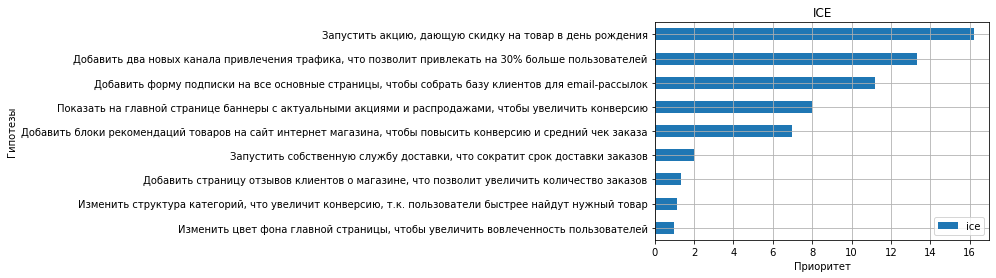

In [23]:
ax = hypothesis[['hypothesis', 'ice']].set_index('hypothesis').sort_values('ice',ascending=True).plot(kind='barh', grid = True)
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотезы')
ax.set_title('ICE')
plt.show

**Вывод по ICE:**
Гипотезы 1,5,3,4 по методике ICE сильно отстают.  
А гипотезы 8,0,7  находятся в лидерах.

### RICE (reach, impact, confidence, effort)

In [24]:
hypothesis['rice'] =((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'])
display(hypothesis[['hypothesis' , 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<function matplotlib.pyplot.show(close=None, block=None)>

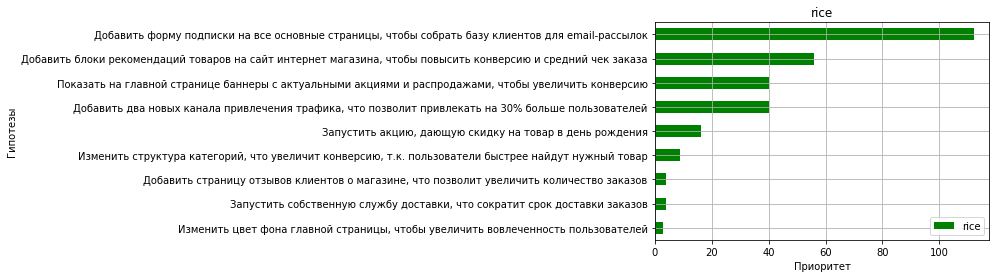

In [25]:
ax = hypothesis[['hypothesis', 'rice']].set_index('hypothesis').sort_values('rice',ascending=True).plot(kind='barh', grid = True, color = 'green')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотезы')
ax.set_title('rice')
plt.show

**Вывод по RICE:**  
Наиболее перспективными по методике RICE выглядят гипотезы 7,2,0,6, остальные же гипотезы сильно отстают.

### Вывод по приоритизации гипотез

Наилучшими вариантами по методике ICE выглядели гипотезы: 
- №8 Запустить акцию, дающую скидку на товар в день рождения
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

А наилучшими гипотезами по методике RICE стали:
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- №2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Гипотеза №8 не вошла в топ по RICE т.к. у неё низкий охват, а гипотеза №2 не показала хороших результатов в ICE т.к. у неё низкий показатель влияния и усилий.  

При перекрестной оценке наиболее приоритетными гипотезами становятся:
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  

А также, ввиду неплохих результатов по обеим метрикам, считаю возможным добавить в приоритеты гипотезу:  
- №6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

## Анализ A/B-теста 
**Создаем массив данных**

In [26]:
# задаем уникальные пары дат и групп
date_group = orders[['date','group']].drop_duplicates()

# кумулятивные данные о заказах по дням 
orders_aggregated = (
    date_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                .sort_values(by=['date','group'])
)
#кумулятивные данные о посетителях магазина по дням  
visitors_aggregated = (
    date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
              .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
              .sort_values(by=['date','group'])
)
# объединяем кумулятивные данные 
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'customers', 'revenue', 'visitors']

display(cumulative_data.head(5)) 
display(cumulative_data['date'].max())
display(cumulative_data['date'].min())

,date,group,orders,customers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

In [27]:
# разделим на группы для построения графика
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
display(cumulative_revenue_a.head())
display(cumulative_revenue_b.head())

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


### График кумулятивной выручки по группам.

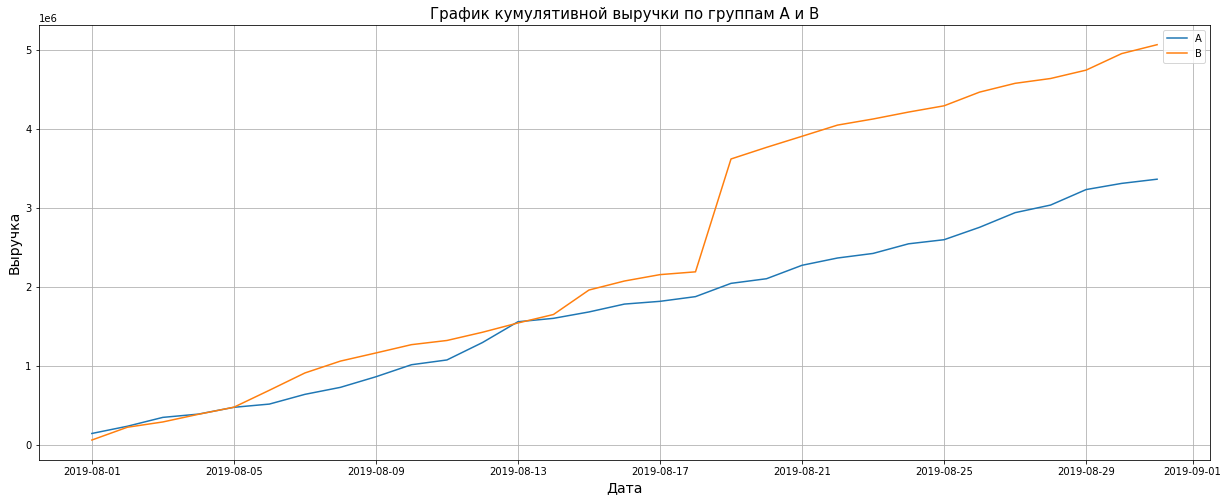

In [28]:
# Задаем данные для графика
plt.figure(figsize=(21, 8))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.grid(True)
plt.title('График кумулятивной выручки по группам А и В', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Выручка', fontsize=14)
plt.legend();

**Промежуточный итог:**  
По графику видно что кумулятивная выручка растет весь наблюдаемый период.  
При этом отмечаем, что группа А растет стабильно, а у группы В виден скачок роста 18-19 августа, это может говорить об увеличении стоимости заказов в группе и/или увеличении количества заказов. 

### График кумулятивного среднего чека по группам.

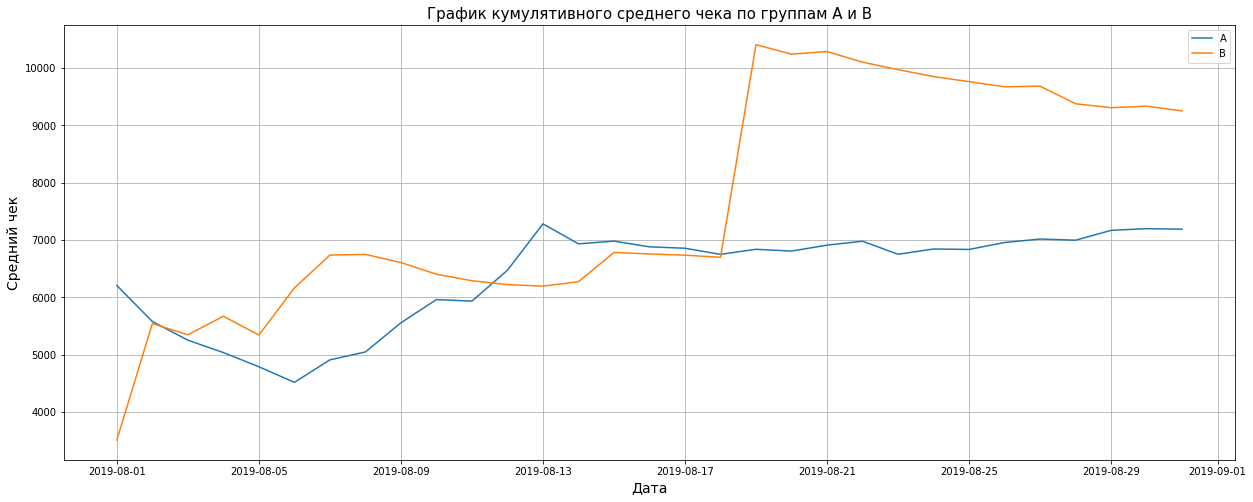

In [29]:
#задаем данные для графика
plt.figure(figsize=(21, 8))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.grid(True)
plt.title('График кумулятивного среднего чека по группам А и В', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Средний чек', fontsize=14)
plt.legend();

**Промежуточный итог:**  
График кумулятивного среднего чека по группам показывает что группа А изначально была "дороже", но все же уступает большую часть времени,а также она имела скачок к 13 августа, а далее стабилизировалась. Группа В растет скачками, что может говорить о резких всплесках покупок дорогих товаров(в следствии участия в каких либо акциях). 

### График относительного изменения кумулятивного среднего чека группы B к группе A.

In [30]:
# для построения относительного графика объединяем кумулятивы
cumulative_revenue =(cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B']))
display(cumulative_revenue.head()) 

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


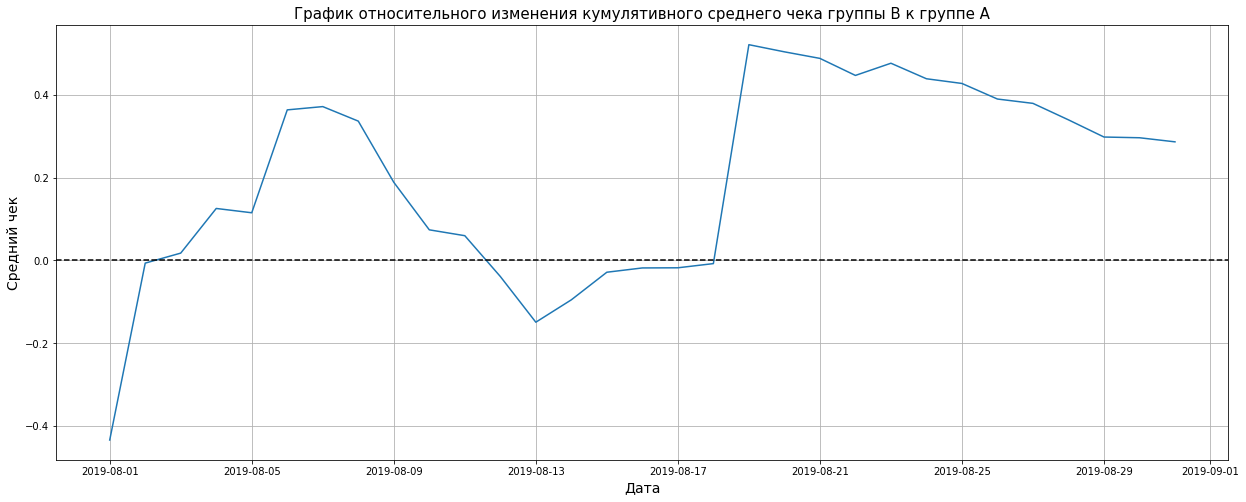

In [31]:
plt.figure(figsize=(21, 8))

plt.plot(cumulative_revenue['date'], (cumulative_revenue['revenueB']/cumulative_revenue['ordersB'])/(cumulative_revenue['revenueA']/cumulative_revenue['ordersA'])-1)

plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Средний чек', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--');

**Промежуточный итог:**  
График сильно скачет в некоторых датах, что подтверждает теорию о всплесках дорогих покупок. 

### График кумулятивного среднего количества заказов на посетителя по группам.

In [32]:
# здесь нам понадобится конверсия
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
display(cumulative_data.head())

,date,group,orders,customers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772


In [33]:
#теперь разделим по группам
cumulative_conversion_a = cumulative_data[cumulative_data['group']=='A']
cumulative_conversion_b = cumulative_data[cumulative_data['group']=='B']
display(cumulative_conversion_a.head())
display(cumulative_conversion_b.head())

,date,group,orders,customers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


,date,group,orders,customers,revenue,visitors,conversion
1,2019-08-01,B,17,17,59758,713,0.023843
3,2019-08-02,B,40,39,221801,1294,0.030912
5,2019-08-03,B,54,53,288850,1803,0.029950
7,2019-08-04,B,68,66,385740,2573,0.026428
9,2019-08-05,B,89,87,475648,3280,0.027134


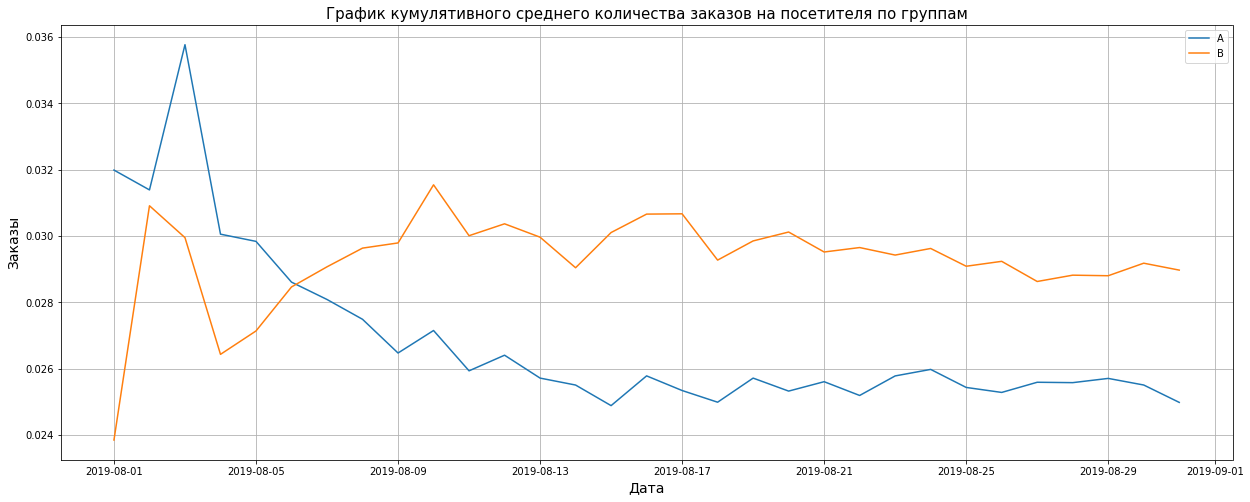

In [34]:
#задаем график
plt.figure(figsize=(21, 8))

plt.plot(cumulative_conversion_a['date'], cumulative_conversion_a['conversion'], label='A')
plt.plot(cumulative_conversion_b['date'], cumulative_conversion_b['conversion'], label='B')

plt.grid(True)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Заказы', fontsize=14)
plt.legend()

**Промежуточный итог:**  
По графику мы видим, что в начале теста у группы А конверсия лучше чем у группы В. В дальнейшем группа В растет и обгоняет группу А которая после роста конверсии в начале, падает и выравнивается. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [35]:
# для построения относительного графика объединяем кумулятивы
cumulative_conversion = (cumulative_conversion_a[['date','conversion']].merge(cumulative_conversion_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']))
display(cumulative_conversion.head())

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


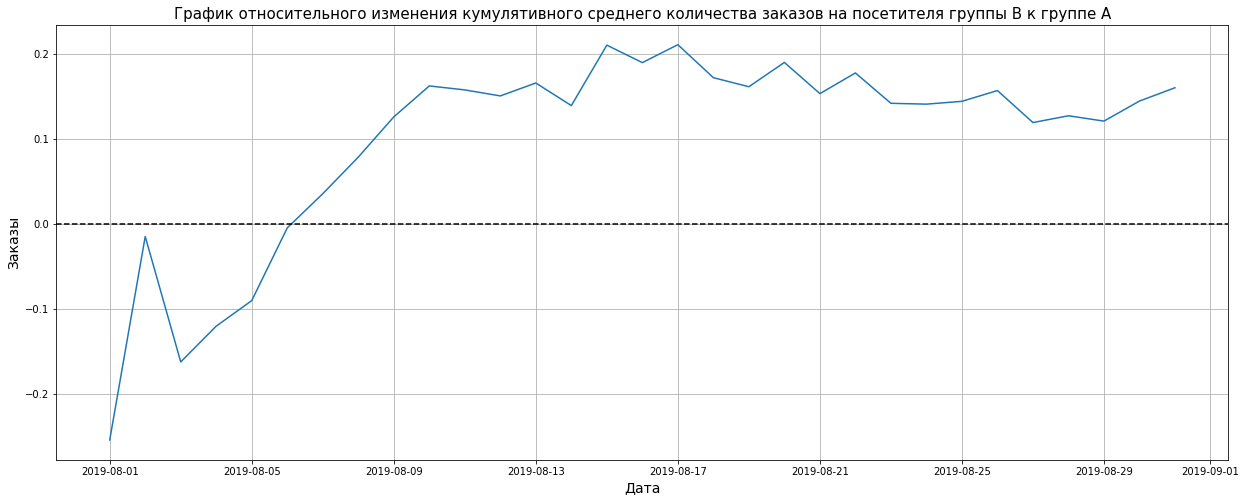

In [36]:
#задаем график
plt.figure(figsize=(21, 8))

plt.plot(cumulative_conversion['date'], cumulative_conversion['conversionB']/cumulative_conversion['conversionA']-1)

plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Заказы', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--')

**Промежуточный итог:**  
График показывает что относительное кумулятивное среднее количество заказов на посетителя в группе В стабильно выше после "обгона" к 6 августа. 

### Точечный график количества заказов по пользователям.

In [37]:
#группировка заказов по пользователям
orders_by_visitors = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_visitors.columns = ['visitor_id', 'orders']
display(orders_by_visitors.head())
display(orders_by_visitors.info())

,visitor_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 0 to 972
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   visitor_id  973 non-null    int64
 1   orders      973 non-null    int64
dtypes: int64(2)
memory usage: 22.8 KB


None

Text(0, 0.5, 'Заказы')

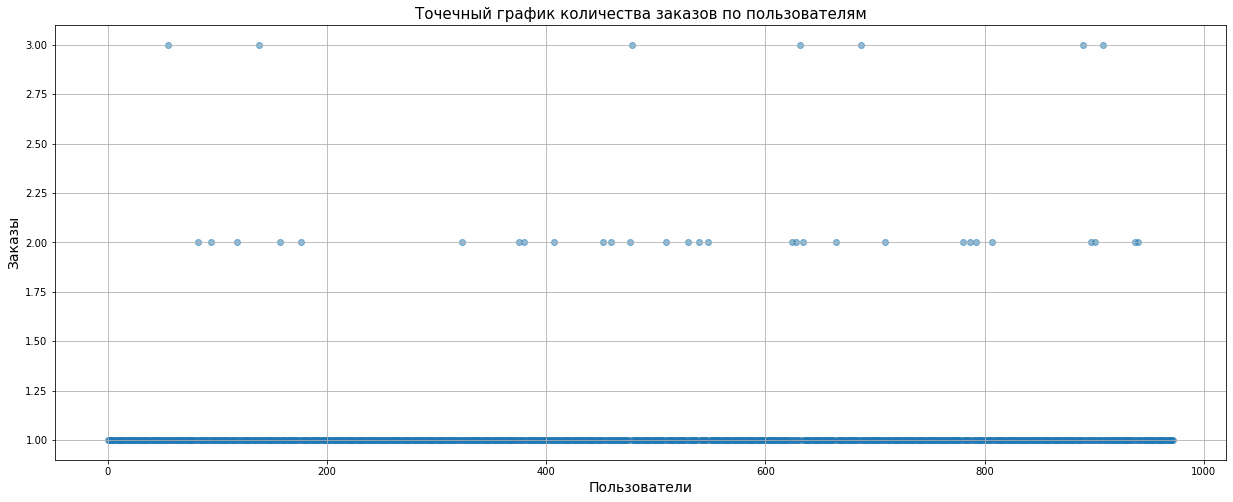

In [38]:
#точечный график
x_values = pd.Series(range(0,len(orders_by_visitors)))

plt.figure(figsize=(21, 8))
plt.scatter(x_values, orders_by_visitors['orders'], alpha=0.5)
plt.grid(True)
plt.title('Точечный график количества заказов по пользователям', fontsize=15)
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Заказы', fontsize=14)

In [39]:
display(orders_by_visitors['orders'].describe())

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

**Промежуточный итог:**  
График и описание показывают что почти все покупатели заказывали 1 раз, но имеются сведения и о тех кто совершал 2 и 3 покупки. 

### 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

In [40]:
np.percentile(orders_by_visitors['orders'], [95, 99])

array([1., 2.])

**Промежуточный итог:**  
Не более 5% заказывали больше 1 раза. И не более 1% закалывали больше 2 раз. 
Выберем не больше 1 заказа на одного пользователя за границу количества заказов на пользователя. 

### Точечный график стоимостей заказов.

Text(0, 0.5, 'Заказы')

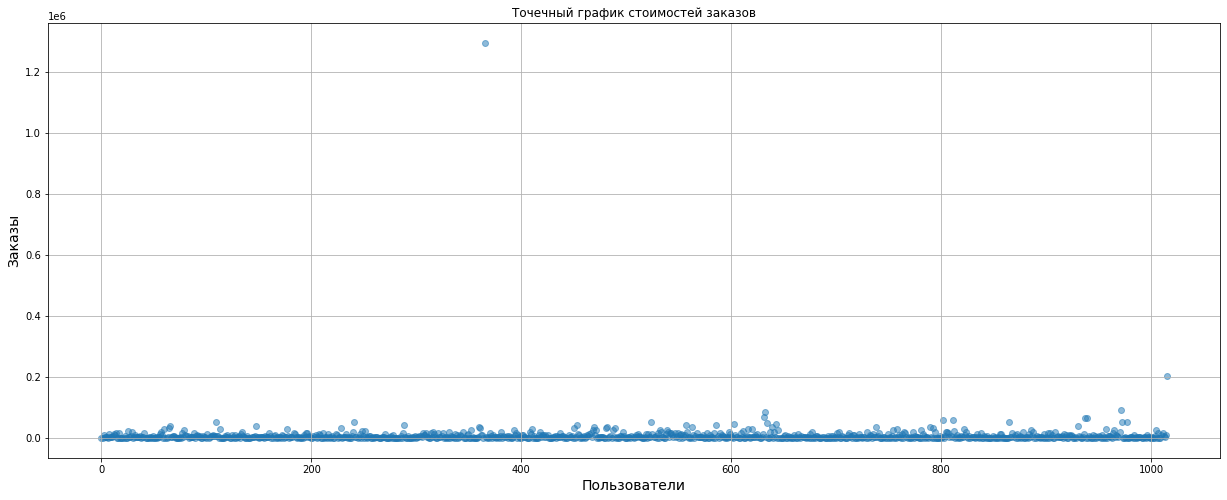

In [41]:
#точечный график  
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(21,8))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.grid(True)
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Заказы', fontsize=14)

**Промежуточный итог:**  
График без установления границ по вертикали не отображает должным образом необходимую информацию, т.к. мешают выбросы. Перестроим график после установления 95 и 99 персентиля. 

### 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

In [42]:
# посчитаем выборочные перцентили стоимости заказов
percent_95_99 = np.percentile(orders['revenue'], [95, 99])
print('95 перцентиль = {} . 99 перцентиль = {}'.format(percent_95_99[0], percent_95_99[1]))

95 перцентиль = 26785.0 . 99 перцентиль = 53904.0


In [43]:
out_users_id = pd.concat([orders_by_visitors[orders_by_visitors['orders'] >=3]['visitor_id'], \
           orders[orders['revenue'] >= percent_95_99[0]]['visitor_id']], axis = 0).drop_duplicates()
len(out_users_id)

58

(0.0, 54000.0)

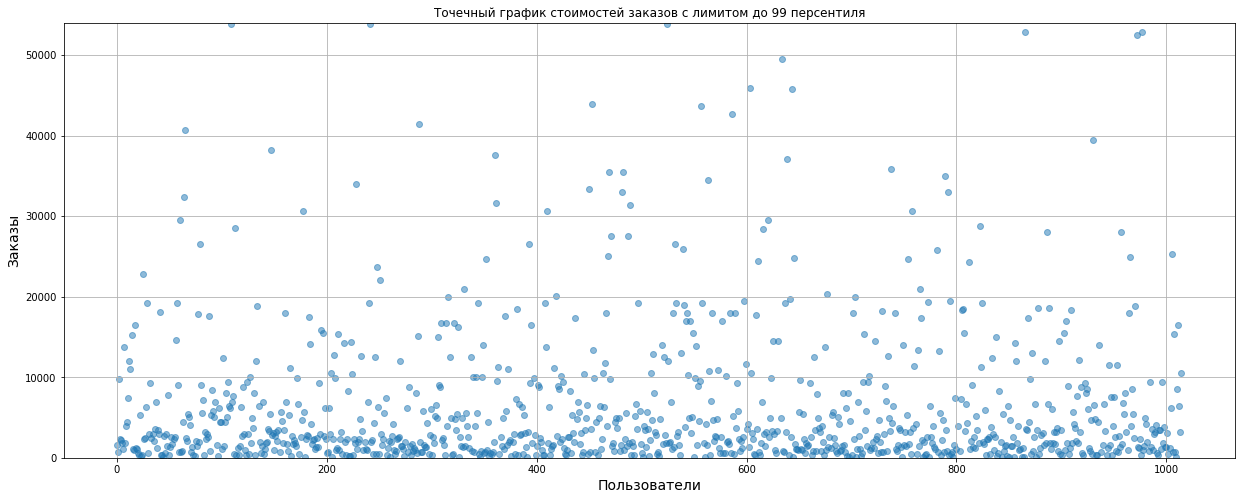

In [44]:
#точечный график  
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(21,8))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.grid(True)
plt.title('Точечный график стоимостей заказов с лимитом до 99 персентиля')
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Заказы', fontsize=14)
plt.ylim([0, 54000])#лимит до 54000, по 99 персентилю.

**Промежуточный итог:**  
Не более 5% покупателей имеют сумму заказа больше чем 26785. И не более 1% имеют сумму заказа больше чем 53904. Установим границу в 53904. И только 58 покупателей приобрели на более чем 53904.
Имея эти данные мы смогли перестроить точечный график стоимостей заказов, установив лимит в 54000(просто округление 99-го персентиля). Теперь график более информативен.  
Чем ниже стоимость заказа, тем их и больше, но распределение количества клиентов в разных диапазонах идёт равномерно.

### Итог по графикам.
По графикам мы видели что в наблюдаемый период происходили различного рода выбросы и в основном происходил скачкообразный рост и стабилизация у группы В.
Точечные графики и персентили продемонстрировали распределение покупок, так например выяснилось что менее 5% покупателей делают больше 2 покупок. А точечный график стоимостей заказов показал что 99% покупателей имеют сумму заказа менее чем 53904, но при это распределение количества клиентов идет равномерно. 


## Статистическая значимость.
ЗДесь и далее:  
H_0 - нулевая гипотеза : различия в выборках не являются статистически значимыми  
H_1 - альтернативная гипотеза : выборки различаются   
alpha = 0.05  
Используеться непараметрический тест Уилкоксона-Манна-Уитни

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

In [45]:
#посчитаем количество заказов на покупателя в каждой группе
orders_a_by_user = orders.query('group == "A"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_a_by_user.columns = ['visitor_id_a', 'n_orders']

orders_b_by_user = orders.query('group == "B"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_b_by_user.columns = ['visitor_id_b', 'n_orders']

# соеденим их
sample_a = pd.concat([orders_a_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - len(orders_a_by_user)))],axis = 0 )

sample_b = pd.concat([orders_b_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - len(orders_b_by_user)))], axis = 0)

In [46]:
#проверяем
alpha = 0.05

print('Различие : {0:.1%}'.format(sample_b.mean() / sample_a.mean() - 1))
print('P-value = {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))

Различие : 16.0%
P-value = 0.011


**Промежуточный итог:**  
(P-value = 0.011)<(alpha = 0.05), нулевая гипотеза отвергнута, выборки различаются.  
Сырые данные говорят, что между группами есть статистически значимые различия в 16%. 

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [47]:
print('Различие:', '{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
print('P-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

Различие: 28.7%
P-value: 0.829


**Промежуточный итог:**  
(P-value = 0.829)>(alpha = 0.05), нельзя отвергнуть нулевую гипотезу, различия в выборках не являются статистически значимыми.    
Сырые данные говорят о том что имееться различие в 28.7%, но P-value не дает говорить о значимости отличий. 

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [48]:
# фильтр "очистки" пользователей
orders_filtr = orders[np.logical_not(orders['visitor_id'].isin(out_users_id))]

# Посчитаем количество заказов на покупателя в каждой группе
orders_a_by_user = orders_filtr.query('group == "A"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_a_by_user.columns = ['visitor_id_a', 'n_orders']

orders_b_by_user = orders_filtr.query('group == "B"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_b_by_user.columns = ['visitor_id_b', 'n_orders']

#объединяем
sample_a = pd.concat([orders_a_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - len(orders_a_by_user)))],axis = 0 )

sample_b = pd.concat([orders_b_by_user['n_orders'] ,\
pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - len(orders_b_by_user)))], axis = 0)

In [49]:
#проверяем
alpha = 0.05

print('Различие : {0:.1%}'.format(sample_b.mean() / sample_a.mean() - 1))
print('P-value = {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))

Различие : 18.2%
P-value = 0.012


**Промежуточный итог:**
(P-value = 0.012)<(alpha = 0.05), нулевая гипотеза отвергнута, выборки различаются. P-value немного вырос в сравнении с "сырыми" данными.  
Очищенные данные говорят, что между группами есть статистически значимые различия в 18.2%, что уже на 2,2% выше чем с "сырыми" данными.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [50]:
clean_orders_a = orders[np.logical_not(orders['visitor_id'].isin(out_users_id))].query('group == "A"')
clean_orders_b = orders[np.logical_not(orders['visitor_id'].isin(out_users_id))].query('group == "B"')

In [51]:
print('Различие : {0:.1%}'.format(clean_orders_a['revenue'].mean() /clean_orders_b['revenue'].mean() - 1))
print('p-value = {0:.3f}'.format(st.mannwhitneyu(clean_orders_a['revenue'],clean_orders_b['revenue'])[1]))

Различие : 5.1%
p-value = 0.646


**Промежуточный итог:**  
(P-value = 0.646)>(alpha = 0.05), нельзя отвергнуть нулевую гипотезу, различия в выборках не являются статистически значимыми, хоть и P-value значительно снизилась (было 0.829) 

Очищенные данные говорят о том что имееться различие в 5.1%, что сильно меньше чем при "сырых" данных (28.7%). 

## Выводы исследования.

На основании данных, предоставленных маркетинговым отделом интернет-магазина был проведено исследование с использованием двух метрик ICE и RICE.
Наиболее приоритетными по метрике ICE, выглядят гипотезы:

- Запуск акции, дающую скидку на товар в день рождения
- Добавление двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

А наилучшими гипотезами по методике RICE(отличие в нацеленности на охват аудитории) стали:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**При перекрестной оценке наиболее приоритетными гипотезами становятся:**

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
А также, ввиду неплохих результатов по обеим метрикам, считаю возможным добавить в приоритеты гипотезу:

- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

В части А\Б теста:

- имеются различия в среднем количестве заказов как по "сырым"(16%) так и по "очищенным"(18.2%) данным. Группа В показывает себя лучше в изучаемый период по росту среднего количества заказов на посетителя чем группа А. Также присутствие статистически значимых отличий в "сырых"((P-value = 0.011)<(alpha = 0.05)) и "очищенных"((P-value = 0.012)<(alpha = 0.05)) данных подтверждает непараметрический тест Уилкоксона-Манна-Уитни.
- статистически значимых различий в среднем чеке заказа между группами непараметрическим тестом Уилкоксона-Манна-Уитни не обнаружено, как в "сырых"(P-value = 0.829)>(alpha = 0.05) так и в "очищенных"(P-value = 0.646)>(alpha = 0.05) данных. В сырых данных различие составляло 28.7%, а в "очищенных" 5.1%, что является огромной разницей, скорее всего были "отфильтрованы" немногочисленные, но самые "дорогие" покупатели из группы В. 
- *Исходя из вышеперечисленного, тест стоит остановить и признать успешным. Группа В показала себя лучше в росте среднего количества заказов на посетителя. В среднем чеке группы А и В показали себя одинаково*